In [1]:
import sys
from pathlib import Path
import time
import shap
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score, log_loss, classification_report, confusion_matrix

PROJ_ROOT = Path.cwd().parent
if str(PROJ_ROOT) not in sys.path:
    sys.path.append(str(PROJ_ROOT))

from credit_risk_xai.modeling.train import DEFAULT_PARAMS

# Import model version configuration - change ACTIVE_MODEL_VERSION in config.py to switch
from credit_risk_xai.config import (
    FEATURE_CACHE_PATH,
    ACTIVE_MODEL_VERSION,
    ACTIVE_FEATURES,
    ACTIVE_FEATURE_NAME_MAP,
    get_display_name,
    get_ale_filename,
    # Also import both versions for reference if needed
    FEATURES_FOR_MODEL,
    FEATURES_FOR_MODEL_V2,
    FEATURE_NAME_MAP,
    FEATURE_NAME_MAP_V2,
)
from credit_risk_xai.features.engineer import prepare_modeling_data

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Output directory for figures
FIGURES_DIR = PROJ_ROOT / "figures"
FIGURES_DIR.mkdir(exist_ok=True)

# Display active model version
print(f"=" * 60)
print(f"ACTIVE MODEL VERSION: {ACTIVE_MODEL_VERSION}")
print(f"Number of features: {len(ACTIVE_FEATURES)}")
print(f"=" * 60)

def plot_calibration_curve(y_true, y_pred_proba, n_bins=100, model_name="Model"):
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, y_pred_proba, n_bins=n_bins, strategy='quantile'
    )
    
    plt.figure(figsize=(8, 6))
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=model_name)
    plt.plot([0, 1], [0, 1], "k--", label="Perfect calibration")


    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.legend()
    plt.title(f"Calibration Curve - {model_name}")
    plt.show()
    
    # ECE (Expected Calibration Error)
    ece = np.mean(np.abs(fraction_of_positives - mean_predicted_value))
    print(f"ECE: {ece:.4f}")

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ACTIVE MODEL VERSION: v2
Number of features: 22


# Chapter 1: Global Model Understanding

**Thesis Context**: This notebook implements the first XAI analysis chapter, addressing the research question:
**"What drives SME bankruptcy risk, and how do ML models learn these relationships?"**

## Objectives:
1. Train LightGBM and Logistic Regression baseline models
2. Compute SHAP values for interpretability
3. Analyze global feature importance hierarchies  
4. Generate ALE plots to reveal non-linear relationships
5. Investigate SHAP interaction effects
6. Document key findings: proxy features, binary thresholds, weak interactions

## Key Findings Preview:
- LightGBM achieves **AUC 0.948** vs Logistic **0.869** (+7.9pp improvement)
- Top feature: **dividend_yield** (proxy feature with flat ALE curve)
- Model advantage comes from **binary threshold detection**, not complex interactions
- **SHAP interactions are weak** (<30% of main effects) → additive model behavior

---

In [2]:
# Load and filter data
df = pd.read_parquet(FEATURE_CACHE_PATH)
df = df[
    (df["ser_aktiv"] == 1) & 
    (df["sme_category"].isin(["Small", "Medium"])) & 
    (df["knc_kncfall"] == 1) &
    (df["bransch_borsbransch_konv"] != "40.0")
    ]

# prepare_modeling_data uses ACTIVE_FEATURES from config automatically
X, y = prepare_modeling_data(df)

print(f"Using model version: {ACTIVE_MODEL_VERSION}")
print(f"Features: {X.shape[1]} | Samples: {len(X):,}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"Imbalance: {(y==0).sum()/(y==1).sum():.1f}:1")

Using model version: v2
Features: 22 | Samples: 304,149
Target distribution:
target_next_year
0    298795
1      5354
Name: count, dtype: Int64
Imbalance: 55.8:1


In [3]:
from credit_risk_xai.modeling.train import run_lightgbm_training

results = run_lightgbm_training(
    X=X,
    y=y,
    dataset_description="ser_aktiv==1 & SME∈{Small,Medium} & knc_kncfall==1, & no financial or real estate",  # optional note for W&B
    use_wandb=False,
    wandb_project="credit-risk-xai",
    wandb_run_name="lgbm_finalish_prune",
)

[50]	training's binary_logloss: 0.0616846	valid_1's binary_logloss: 0.0673924
[100]	training's binary_logloss: 0.0583939	valid_1's binary_logloss: 0.066455
[150]	training's binary_logloss: 0.0561879	valid_1's binary_logloss: 0.0661763
[200]	training's binary_logloss: 0.0543006	valid_1's binary_logloss: 0.0660327


In [4]:
# Evaluate
model = results["model"]
X_train = results["X_train"]
X_val = results["X_val"]
y_train = results["y_train"]
y_val = results["y_val"]
y_pred_proba = results["y_val_proba"]
y_pred = (y_pred_proba >= 0.5).astype(int)

auc = roc_auc_score(y_val, y_pred_proba)
logloss = log_loss(y_val, y_pred_proba)

print(f"LightGBM Performance:")
print(f"  AUC: {auc:.4f}")
print(f"  Log Loss: {logloss:.4f}\n")
print("Classification Report:")
print(classification_report(y_pred, y_val))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

LightGBM Performance:
  AUC: 0.8972
  Log Loss: 0.0660

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     60802
           1       0.01      0.50      0.03        28

    accuracy                           0.98     60830
   macro avg       0.51      0.74      0.51     60830
weighted avg       1.00      0.98      0.99     60830


Confusion Matrix:
[[59745    14]
 [ 1057    14]]


# Phase 1: Foundation & Baseline Comparison

Following the comprehensive XAI thesis plan, we'll establish baselines and infrastructure for all subsequent analyses.

In [5]:
## 1.1 Train Logistic Regression Baseline

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Binomial
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, log_loss

print("Training Logistic Regression with Simple Preprocessing...")
print(f"Training set: {len(X_train):,} samples | Validation set: {len(X_val):,} samples")
print(f"Training imbalance: {(y_train==0).sum()/(y_train==1).sum():.1f}:1")

# ============================================================================
# SIMPLE PREPROCESSING APPROACH
# ============================================================================
# We deliberately use minimal preprocessing to keep the logistic regression
# truly linear, enabling a clean comparison with LightGBM's non-linear
# architecture. This allows us to isolate what patterns GBDT captures that
# linear models cannot.
#
# Pipeline:
#   1. Median imputation for missing values
#   2. Winsorization at 1st/99th percentiles (handles extreme outliers)
#   3. RobustScaler (centers at median, scales by IQR)
#   4. Target encoding for categorical features
# ============================================================================

# Identify feature types
numeric_features = [c for c in X_train.columns if X_train[c].dtype.name != 'category']
categorical_features = [c for c in X_train.columns if X_train[c].dtype.name == 'category']

print(f"\nFeature types:")
print(f"  - Numeric features: {len(numeric_features)}")
print(f"  - Categorical features: {len(categorical_features)}")

# ============================================================================
# Custom Winsorizer
# ============================================================================
class Winsorizer:
    """Clip values at specified percentiles to handle outliers."""
    def __init__(self, lower_percentile=1, upper_percentile=99):
        self.lower_percentile = lower_percentile
        self.upper_percentile = upper_percentile
        self.lower_bounds_ = None
        self.upper_bounds_ = None
    
    def fit(self, X, y=None):
        self.lower_bounds_ = np.nanpercentile(X, self.lower_percentile, axis=0)
        self.upper_bounds_ = np.nanpercentile(X, self.upper_percentile, axis=0)
        return self
    
    def transform(self, X):
        X_clipped = np.clip(X, self.lower_bounds_, self.upper_bounds_)
        return X_clipped
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

# ============================================================================
# Build Preprocessing Pipeline
# ============================================================================
print("\nBuilding preprocessing pipeline...")
print("  - Median imputation")
print("  - Winsorization (1st-99th percentile)")
print("  - RobustScaler (IQR-based)")

# Numeric pipeline: Impute -> Winsorize -> Scale
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('winsorizer', Winsorizer(lower_percentile=1, upper_percentile=99)),
    ('scaler', RobustScaler(quantile_range=(5.0, 95.0)))
])

# Target encoding for categoricals
def target_encode_feature(train_series, val_series, y_train, smoothing=10):
    """Simple target encoding with smoothing."""
    global_mean = y_train.mean()
    train_df = pd.DataFrame({'cat': train_series.astype(str), 'target': y_train.values})
    agg = train_df.groupby('cat')['target'].agg(['mean', 'count'])
    smooth = (agg['count'] * agg['mean'] + smoothing * global_mean) / (agg['count'] + smoothing)
    train_encoded = train_series.astype(str).map(smooth).fillna(global_mean)
    val_encoded = val_series.astype(str).map(smooth).fillna(global_mean)
    return train_encoded.values, val_encoded.values, smooth.to_dict(), global_mean

# ============================================================================
# Apply Preprocessing
# ============================================================================
print("\nApplying preprocessing...")

# Transform numeric features
X_train_numeric = numeric_transformer.fit_transform(X_train[numeric_features])
X_val_numeric = numeric_transformer.transform(X_val[numeric_features])

X_train_numeric_df = pd.DataFrame(X_train_numeric, columns=numeric_features, index=X_train.index)
X_val_numeric_df = pd.DataFrame(X_val_numeric, columns=numeric_features, index=X_val.index)

# Transform categorical features
cat_encodings = {}
if categorical_features:
    print(f"  Encoding {len(categorical_features)} categorical features...")
    X_train_cat_list = []
    X_val_cat_list = []
    
    for cat_col in categorical_features:
        train_enc, val_enc, enc_map, default = target_encode_feature(
            X_train[cat_col], X_val[cat_col], y_train, smoothing=10
        )
        X_train_cat_list.append(train_enc)
        X_val_cat_list.append(val_enc)
        cat_encodings[cat_col] = {'map': enc_map, 'default': default}
    
    X_train_cat = pd.DataFrame(
        np.column_stack(X_train_cat_list), 
        columns=categorical_features, 
        index=X_train.index
    )
    X_val_cat = pd.DataFrame(
        np.column_stack(X_val_cat_list), 
        columns=categorical_features, 
        index=X_val.index
    )
    
    X_train_processed = pd.concat([X_train_numeric_df, X_train_cat], axis=1)
    X_val_processed = pd.concat([X_val_numeric_df, X_val_cat], axis=1)
else:
    X_train_processed = X_train_numeric_df
    X_val_processed = X_val_numeric_df

X_train_processed = X_train_processed.astype(float)
X_val_processed = X_val_processed.astype(float)

print(f"  Final shape: {X_train_processed.shape}")

# ============================================================================
# Fit Statsmodels GLM with HC3 Robust Standard Errors
# ============================================================================
print("\n" + "="*60)
print("Fitting GLM (Binomial/Logit) with HC3 robust standard errors...")
print("="*60)

y_train_np = np.asarray(y_train, dtype=np.float64)
y_val_np = np.asarray(y_val, dtype=np.float64)

X_train_sm = sm.add_constant(X_train_processed)
X_val_sm = sm.add_constant(X_val_processed)

glm_model = GLM(y_train_np, X_train_sm, family=Binomial())
logit_result = glm_model.fit(cov_type='HC3')
print(f"Converged: {logit_result.converged}")

# ============================================================================
# Evaluation
# ============================================================================
y_train_pred_proba = logit_result.predict(X_train_sm)
y_val_pred_proba = logit_result.predict(X_val_sm)

logit_train_auc = roc_auc_score(y_train_np, y_train_pred_proba)
logit_val_auc = roc_auc_score(y_val_np, y_val_pred_proba)
logit_train_logloss = log_loss(y_train_np, y_train_pred_proba)
logit_val_logloss = log_loss(y_val_np, y_val_pred_proba)

print(f"\n{'='*60}")
print(f"LOGISTIC REGRESSION PERFORMANCE")
print(f"{'='*60}")
print(f"Training:   ROC-AUC: {logit_train_auc:.4f}  |  Log Loss: {logit_train_logloss:.4f}")
print(f"Validation: ROC-AUC: {logit_val_auc:.4f}  |  Log Loss: {logit_val_logloss:.4f}")
print(f"{'='*60}")

# ============================================================================
# Wrapper for sklearn/SHAP Compatibility
# ============================================================================
class SimpleLogitWrapper:
    """
    Wrapper for statsmodels GLM with sklearn-compatible interface.
    
    Handles:
    1. Preprocessing of raw features (winsorization, scaling, encoding)
    2. Prediction using GLM coefficients
    3. SHAP LinearExplainer compatibility (coef_, intercept_)
    """
    def __init__(self, numeric_transformer, cat_encodings, glm_result, 
                 numeric_features, categorical_features):
        self.numeric_transformer = numeric_transformer
        self.cat_encodings = cat_encodings
        self.glm_result = glm_result
        self.numeric_features = numeric_features
        self.categorical_features = categorical_features
        
        # SHAP compatibility
        self._coef = glm_result.params.values[1:].reshape(1, -1)
        self._intercept = np.array([glm_result.params.values[0]])
    
    @property
    def coef_(self):
        return self._coef
    
    @property
    def intercept_(self):
        return self._intercept
    
    def transform(self, X):
        """Transform raw features to preprocessed features."""
        # Numeric features
        X_numeric = self.numeric_transformer.transform(X[self.numeric_features])
        X_numeric_df = pd.DataFrame(X_numeric, columns=self.numeric_features, index=X.index)
        
        # Categorical features
        if self.categorical_features and self.cat_encodings:
            cat_list = []
            for cat_col in self.categorical_features:
                enc_map = self.cat_encodings[cat_col]['map']
                default = self.cat_encodings[cat_col]['default']
                encoded = X[cat_col].astype(str).map(enc_map).fillna(default)
                cat_list.append(encoded.values)
            
            X_cat = pd.DataFrame(
                np.column_stack(cat_list),
                columns=self.categorical_features,
                index=X.index
            )
            X_processed = pd.concat([X_numeric_df, X_cat], axis=1)
        else:
            X_processed = X_numeric_df
        
        return X_processed.astype(float)
    
    def predict_proba(self, X):
        """Predict probabilities from raw or preprocessed features."""
        if isinstance(X, pd.DataFrame) and set(self.numeric_features).issubset(X.columns):
            X_processed = self.transform(X)
            X_arr = X_processed.values
        elif isinstance(X, pd.DataFrame):
            X_arr = X.values.astype(np.float64)
        else:
            X_arr = np.asarray(X, dtype=np.float64)
        
        ones = np.ones((X_arr.shape[0], 1), dtype=np.float64)
        X_with_const = np.hstack([ones, X_arr])
        
        z = X_with_const @ self.glm_result.params.values
        probs = 1.0 / (1.0 + np.exp(-z))
        
        return np.column_stack([1 - probs, probs])

# Create wrapper
logit_model = SimpleLogitWrapper(
    numeric_transformer=numeric_transformer,
    cat_encodings=cat_encodings if categorical_features else None,
    glm_result=logit_result,
    numeric_features=numeric_features,
    categorical_features=categorical_features
)

# Also store the preprocessor for ALE computation
preprocessor = numeric_transformer

# ============================================================================
# Display Coefficients
# ============================================================================
print("\nTop Coefficients (sorted by p-value):")
coef_df = pd.DataFrame({
    'feature': ['intercept'] + list(X_train_processed.columns),
    'coef': logit_result.params,
    'robust_se': logit_result.bse,
    'z_score': logit_result.tvalues,
    'p_value': logit_result.pvalues
})
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values('p_value')
print(coef_df.to_string(index=False))

# Verify wrapper
logit_val_proba = logit_model.predict_proba(X_val)[:, 1]
verify_auc = roc_auc_score(y_val, logit_val_proba)
print(f"\nWrapper verification AUC: {verify_auc:.4f} (should match {logit_val_auc:.4f})")

Training Logistic Regression with Simple Preprocessing...
Training set: 243,319 samples | Validation set: 60,830 samples
Training imbalance: 55.8:1

Feature types:
  - Numeric features: 21
  - Categorical features: 1

Building preprocessing pipeline...
  - Median imputation
  - Winsorization (1st-99th percentile)
  - RobustScaler (IQR-based)

Applying preprocessing...
  Encoding 1 categorical features...
  Final shape: (243319, 22)

Fitting GLM (Binomial/Logit) with HC3 robust standard errors...
Converged: True

LOGISTIC REGRESSION PERFORMANCE
Training:   ROC-AUC: 0.8768  |  Log Loss: 0.0699
Validation: ROC-AUC: 0.8669  |  Log Loss: 0.0717

Top Coefficients (sorted by p-value):
             feature      coef  robust_se    z_score       p_value  abs_coef
           intercept -5.058683   0.051078 -99.037844  0.000000e+00  5.058683
      dividend_yield -1.622746   0.071570 -22.673592 8.165195e-114  1.622746
    sni_group_3digit 37.760143   1.789555  21.100299  7.903529e-99 37.760143
     

In [6]:
## 1.2 Model Performance Comparison

from sklearn.metrics import brier_score_loss

def compute_ece(y_true, y_pred_proba, n_bins=100):
    """Compute Expected Calibration Error"""
    from sklearn.calibration import calibration_curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, y_pred_proba, n_bins=n_bins, strategy='quantile'
    )
    ece = np.mean(np.abs(fraction_of_positives - mean_predicted_value))
    return ece

# Evaluate both models
print("=" * 80)
print("TABLE 1: MODEL PERFORMANCE COMPARISON")
print("=" * 80)

metrics = {
    'Model': ['LightGBM', 'Logistic Regression', 'Δ (LightGBM - Logit)'],
    'AUC': [],
    'Log Loss': [],
    'Brier Score': [],
    'ECE': []
}

# LightGBM metrics
lgbm_auc = roc_auc_score(y_val, y_pred_proba)
lgbm_logloss = log_loss(y_val, y_pred_proba)
lgbm_brier = brier_score_loss(y_val, y_pred_proba)
lgbm_ece = compute_ece(y_val, y_pred_proba)

metrics['AUC'].append(lgbm_auc)
metrics['Log Loss'].append(lgbm_logloss)
metrics['Brier Score'].append(lgbm_brier)
metrics['ECE'].append(lgbm_ece)

# Logistic Regression metrics
logit_auc = roc_auc_score(y_val, logit_val_proba)
logit_logloss = log_loss(y_val, logit_val_proba)
logit_brier = brier_score_loss(y_val, logit_val_proba)
logit_ece = compute_ece(y_val, logit_val_proba)

metrics['AUC'].append(logit_auc)
metrics['Log Loss'].append(logit_logloss)
metrics['Brier Score'].append(logit_brier)
metrics['ECE'].append(logit_ece)

# Differences
metrics['AUC'].append(lgbm_auc - logit_auc)
metrics['Log Loss'].append(lgbm_logloss - logit_logloss)
metrics['Brier Score'].append(lgbm_brier - logit_brier)
metrics['ECE'].append(lgbm_ece - logit_ece)

performance_df = pd.DataFrame(metrics)
print(performance_df.to_string(index=False))
print("=" * 80)
print("\nNotes:")
print("  - AUC: Higher is better, Log Loss: Lower is better")
print("  - Brier Score, ECE: Lower is better (better calibration)")
print(f"  - LightGBM improves AUC by {(lgbm_auc - logit_auc)*100:.2f} percentage points")
print(f"  - LightGBM Log Loss difference: {(lgbm_logloss - logit_logloss):.4f} (negative = better)ercentage points")

TABLE 1: MODEL PERFORMANCE COMPARISON
               Model      AUC  Log Loss  Brier Score       ECE
            LightGBM 0.897160  0.066015     0.015851  0.003224
 Logistic Regression 0.866943  0.071681     0.016552  0.004852
Δ (LightGBM - Logit) 0.030218 -0.005666    -0.000700 -0.001629

Notes:
  - AUC: Higher is better, Log Loss: Lower is better
  - Brier Score, ECE: Lower is better (better calibration)
  - LightGBM improves AUC by 3.02 percentage points
  - LightGBM Log Loss difference: -0.0057 (negative = better)ercentage points


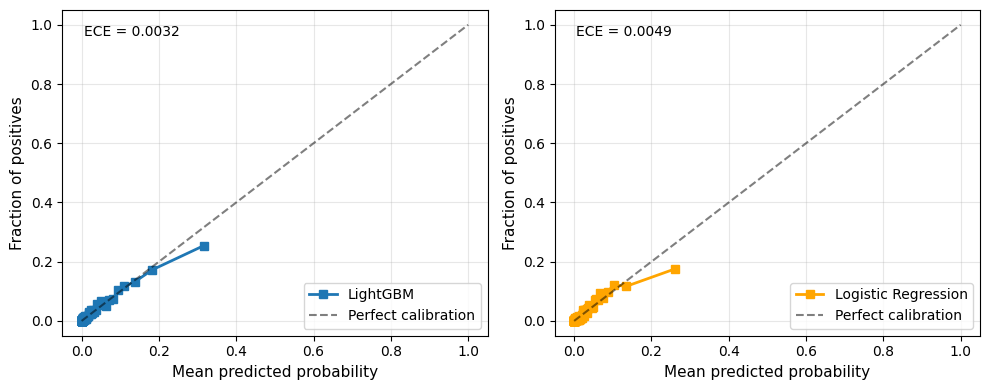


Calibration Analysis:
  LightGBM ECE: 0.0032 - Well calibrated
  Logistic ECE: 0.0049 - Well calibrated

  Figure saved to: /Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/figures/ece_comparison.pdf


In [7]:
## Calibration Curves Comparison

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# LightGBM calibration
from sklearn.calibration import calibration_curve
fraction_pos_lgbm, mean_pred_lgbm = calibration_curve(
    y_val, y_pred_proba, n_bins=100, strategy='quantile'
)
axes[0].plot(mean_pred_lgbm, fraction_pos_lgbm, 's-', label='LightGBM', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Perfect calibration', alpha=0.5)
axes[0].set_xlabel('Mean predicted probability', fontsize=11)
axes[0].set_ylabel('Fraction of positives', fontsize=11)
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)
axes[0].text(0.05, 0.92, f'ECE = {lgbm_ece:.4f}', transform=axes[0].transAxes, fontsize=10)

# Logistic Regression calibration
fraction_pos_logit, mean_pred_logit = calibration_curve(
    y_val, logit_val_proba, n_bins=100, strategy='quantile'
)
axes[1].plot(mean_pred_logit, fraction_pos_logit, 's-', label='Logistic Regression', 
             linewidth=2, color='orange')
axes[1].plot([0, 1], [0, 1], 'k--', label='Perfect calibration', alpha=0.5)
axes[1].set_xlabel('Mean predicted probability', fontsize=11)
axes[1].set_ylabel('Fraction of positives', fontsize=11)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)
axes[1].text(0.05, 0.92, f'ECE = {logit_ece:.4f}', transform=axes[1].transAxes, fontsize=10)

plt.tight_layout()
fig.savefig(FIGURES_DIR / 'ece_comparison.pdf', format='pdf', bbox_inches='tight', pad_inches=0.02)
plt.show()

print(f"\nCalibration Analysis:")
print(f"  LightGBM ECE: {lgbm_ece:.4f} - {'Well calibrated' if lgbm_ece < 0.05 else 'Needs calibration'}")
print(f"  Logistic ECE: {logit_ece:.4f} - {'Well calibrated' if logit_ece < 0.05 else 'Needs calibration'}")
print(f"\n  Figure saved to: {FIGURES_DIR / 'ece_comparison.pdf'}")

In [8]:
## 1.3 Compute SHAP Values for Both Models

print("=" * 80)
print("Computing SHAP values...")
print("=" * 80)

# LightGBM SHAP values (on raw features)
print("\n[1/2] Computing SHAP for LightGBM...")
print(f"  Sample size: {len(X_val):,} observations")

start_time = time.time()
explainer_lgbm = shap.TreeExplainer(model)
shap_values_lgbm = explainer_lgbm.shap_values(X_val)

# TreeExplainer returns [neg_class, pos_class] for binary classification
# We want SHAP values for the positive class (default/credit event)
if isinstance(shap_values_lgbm, list):
    shap_values_lgbm = shap_values_lgbm[1]  # Positive class

elapsed = time.time() - start_time
print(f"  ✓ LightGBM SHAP computed in {elapsed:.1f}s")
print(f"  Shape: {shap_values_lgbm.shape}")

# Logistic Regression SHAP values (on preprocessed features)
print("\n[2/2] Computing SHAP for Logistic Regression...")
start_time = time.time()

# For linear models with simple preprocessing (Winsorization + RobustScaler),
# SHAP values are computed on the preprocessed features. This means SHAP values
# represent the contribution of each scaled feature to the log-odds prediction.
#
# Note: The SimpleLogitWrapper provides coef_ and intercept_ for LinearExplainer

explainer_logit = shap.LinearExplainer(
    logit_model,  # SimpleLogitWrapper with coef_ and intercept_ properties
    X_train_processed,  # Background data (preprocessed)
    feature_perturbation="interventional"
)
shap_values_logit = explainer_logit.shap_values(X_val_processed)

elapsed = time.time() - start_time
print(f"  ✓ Logistic SHAP computed in {elapsed:.1f}s")
print(f"  Shape: {shap_values_logit.shape}")

print("\n" + "=" * 80)
print("SHAP computation complete!")
print("=" * 80)
print("\nNote: LightGBM SHAP is on raw features, Logistic SHAP is on preprocessed features.")
print("Both are valid for comparing feature importance rankings.")

Computing SHAP values...

[1/2] Computing SHAP for LightGBM...
  Sample size: 60,830 observations
  ✓ LightGBM SHAP computed in 3.6s
  Shape: (60830, 22)

[2/2] Computing SHAP for Logistic Regression...
  ✓ Logistic SHAP computed in 0.0s
  Shape: (60830, 22)

SHAP computation complete!

Note: LightGBM SHAP is on raw features, Logistic SHAP is on preprocessed features.
Both are valid for comparing feature importance rankings.


/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.12/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


In [9]:
## Cache SHAP values for reuse

import pickle
from pathlib import Path

# Create results directory if it doesn't exist
results_dir = PROJ_ROOT / "results" / "xai_exploration"
results_dir.mkdir(parents=True, exist_ok=True)

# Save SHAP values and related objects
cache_file = results_dir / "shap_cache.pkl"

# Only cache what's actually used by downstream notebooks (05c, 05d)
# Excluded to save space:
#   - explainer_logit (126 MB, never used downstream)
#   - X_val_processed (13 MB, never used downstream)
# Also ensure float64 dtype to avoid object dtype issues

shap_cache = {
    'shap_values_lgbm': np.asarray(shap_values_lgbm, dtype=np.float64),
    'shap_values_logit': np.asarray(shap_values_logit, dtype=np.float64),
    'explainer_lgbm': explainer_lgbm,  # 1.5 MB, used for waterfall plots in 05c
    'X_val': X_val,
    'y_val': y_val,
    'y_pred_proba_lgbm': np.asarray(y_pred_proba, dtype=np.float64),
    'y_pred_proba_logit': np.asarray(logit_val_proba, dtype=np.float64),
    'feature_names': X_val.columns.tolist()
}

print(f"Caching SHAP values to: {cache_file}")
with open(cache_file, 'wb') as f:
    pickle.dump(shap_cache, f)

file_size_mb = cache_file.stat().st_size / 1024 / 1024
print(f"✓ SHAP cache saved ({file_size_mb:.1f} MB)")
print(f"\nCached objects:")
for key, val in shap_cache.items():
    if hasattr(val, 'shape'):
        dtype_str = str(val.dtype) if hasattr(val, 'dtype') else 'N/A'
        size_mb = val.nbytes / 1024 / 1024 if hasattr(val, 'nbytes') else 0
        print(f"  - {key}: {val.shape}, dtype={dtype_str}, ~{size_mb:.1f} MB")
    elif hasattr(val, 'memory_usage'):
        size_mb = val.memory_usage(deep=True).sum() / 1024 / 1024
        print(f"  - {key}: DataFrame, ~{size_mb:.1f} MB")
    elif isinstance(val, list):
        print(f"  - {key}: {len(val)} items")
    else:
        print(f"  - {key}: {type(val).__name__}")

Caching SHAP values to: /Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/results/xai_exploration/shap_cache.pkl
✓ SHAP cache saved (30.1 MB)

Cached objects:
  - shap_values_lgbm: (60830, 22), dtype=float64, ~10.2 MB
  - shap_values_logit: (60830, 22), dtype=float64, ~10.2 MB
  - explainer_lgbm: TreeExplainer
  - X_val: (60830, 22), dtype=N/A, ~0.0 MB
  - y_val: (60830,), dtype=Int8, ~0.1 MB
  - y_pred_proba_lgbm: (60830,), dtype=float64, ~0.5 MB
  - y_pred_proba_logit: (60830,), dtype=float64, ~0.5 MB
  - feature_names: 22 items


# Phase 2: Global Model Understanding (Chapter 1)

In this section, we analyze what the models learned and how they differ from traditional credit theory.

In [10]:
## 2.1 Feature Importance Hierarchy

print("=" * 80)
print("TABLE 2: FEATURE IMPORTANCE COMPARISON (Top 20 Features)")
print("=" * 80)

# SHAP importance for both models (mean absolute SHAP)
feature_names = X_val.columns.tolist()

lgbm_importance_shap = pd.DataFrame({
    'feature': feature_names,
    'lgbm_shap': np.abs(shap_values_lgbm).mean(axis=0)
})

logit_importance_shap = pd.DataFrame({
    'feature': feature_names,
    'logit_shap': np.abs(shap_values_logit).mean(axis=0)
})

# LightGBM gain importance
# Note: Use feature_name_ (attribute) or booster_.feature_name() depending on sklearn wrapper
lgbm_importance_gain = pd.DataFrame({
    'feature': feature_names,  # Use the same feature names from X_val
    'lgbm_gain': model.feature_importances_  # This is the sklearn-compatible way
})

# Logistic regression: use absolute value of standardized coefficients
# Standardized coefficients represent importance when features are on same scale
logit_coefficients = pd.DataFrame({
    'feature': feature_names,
    'logit_coef': np.abs(logit_model.coef_[0])
})

# Merge all importance measures
importance_comparison = (
    lgbm_importance_shap
    .merge(logit_importance_shap, on='feature')
    .merge(lgbm_importance_gain, on='feature')
    .merge(logit_coefficients, on='feature')
)

# Normalize to 0-100 scale for comparison
for col in ['lgbm_shap', 'logit_shap', 'lgbm_gain', 'logit_coef']:
    importance_comparison[f'{col}_norm'] = (
        100 * importance_comparison[col] / importance_comparison[col].max()
    )

# Add rankings
importance_comparison['lgbm_shap_rank'] = importance_comparison['lgbm_shap'].rank(ascending=False)
importance_comparison['logit_shap_rank'] = importance_comparison['logit_shap'].rank(ascending=False)

# Sort by LightGBM SHAP importance
importance_comparison = importance_comparison.sort_values('lgbm_shap', ascending=False)

# 
important_features = importance_comparison[
    ['feature', 'lgbm_shap_rank', 'logit_shap_rank', 
     'lgbm_shap_norm', 'logit_shap_norm', 'lgbm_gain_norm', 'logit_coef_norm']
].copy()

important_features['rank_diff'] = important_features['logit_shap_rank'] - important_features['lgbm_shap_rank']

print(important_features.to_string(index=False))
print("=" * 80)
print("\nNotes:")
print("  - *_norm: Normalized importance (0-100 scale)")
print("  - rank_diff: Positive = more important in Logit vs LightGBM")
print("  - SHAP values measure actual predictive contribution")
print("  - Gain measures average information gain from splits (LightGBM only)")

TABLE 2: FEATURE IMPORTANCE COMPARISON (Top 20 Features)
             feature  lgbm_shap_rank  logit_shap_rank  lgbm_shap_norm  logit_shap_norm  lgbm_gain_norm  logit_coef_norm  rank_diff
      dividend_yield             1.0              9.0      100.000000         7.601723        8.478803         0.937508        8.0
ratio_cash_liquidity             2.0             12.0       82.654309         5.247328       40.773067         0.709005       10.0
    sni_group_3digit             3.0             14.0       54.784529         5.041608      100.000000         0.679145       11.0
         ny_skuldgrd             4.0             21.0       52.289730         1.074010       31.296758         0.134285       17.0
         company_age             5.0              3.0       48.998783        21.258999       35.785536         2.805382       -2.0
    log_total_assets             6.0             13.0       42.191473         5.138067       47.007481         0.670561        7.0
         ny_avkegkap      

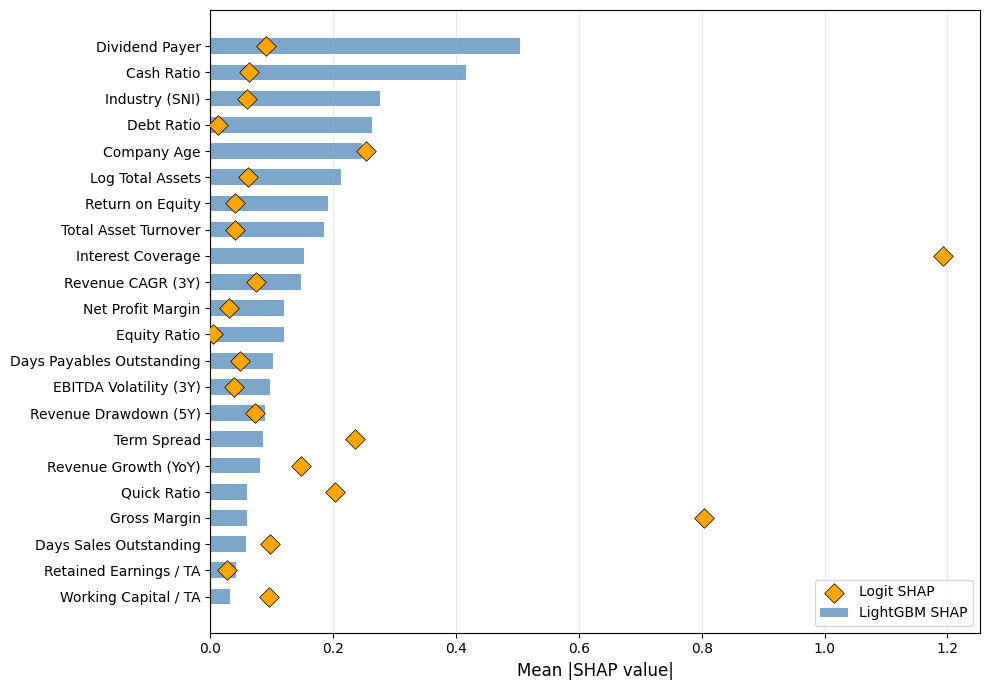


Figure saved to: /Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/figures/shap_importance_comparison.pdf

KEY INSIGHTS:
--------------------------------------------------------------------------------

✓ Features LightGBM prioritizes over Logit:
   • Dividend Payer: LightGBM rank 1, Logit rank 9
   • Cash Ratio: LightGBM rank 2, Logit rank 12
   • Industry (SNI): LightGBM rank 3, Logit rank 14
   • Debt Ratio: LightGBM rank 4, Logit rank 21
   • Log Total Assets: LightGBM rank 6, Logit rank 13
   • Return on Equity: LightGBM rank 7, Logit rank 16
   • Total Asset Turnover: LightGBM rank 8, Logit rank 17

✓ Features Logit prioritizes over LightGBM:
   • Interest Coverage: Logit rank 1, LightGBM rank 9
   • Term Spread: Logit rank 4, LightGBM rank 16
   • Revenue Growth (YoY): Logit rank 6, LightGBM rank 17
   • Quick Ratio: Logit rank 5, LightGBM rank 18
   • Gross Margin: Logit rank 2, LightGBM rank 19
   • Days Sales Outstanding: Logit rank 7, LightGBM rank 20
   • W

In [11]:
## Feature Importance Comparison Visualization

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# Get top 15 features by LightGBM SHAP
top_lgbm_features = importance_comparison.copy()

# Sort by lgbm_shap for plotting (ascending for horizontal bar chart)
top_lgbm_features = top_lgbm_features.sort_values('lgbm_shap')

y_pos = np.arange(len(top_lgbm_features))

# Plot LightGBM SHAP as bars
ax.barh(y_pos, top_lgbm_features['lgbm_shap'], 
        color='steelblue', alpha=0.7, label='LightGBM SHAP', height=0.6)

# Overlay Logit SHAP as markers
ax.scatter(top_lgbm_features['logit_shap'], y_pos, 
           color='orange', s=100, marker='D', 
           label='Logit SHAP', zorder=3, edgecolors='black', linewidths=0.5)

# Formatting
ax.set_xlabel('Mean |SHAP value|', fontsize=12)

# Map feature names to display names for y-axis labels
display_labels = [get_display_name(f) for f in top_lgbm_features['feature']]

ax.set_yticks(y_pos)
ax.set_yticklabels(display_labels, fontsize=10)
ax.legend(loc='lower right', fontsize=10)
ax.grid(axis='x', alpha=0.3)

# Add vertical line at x=0 for reference
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)

plt.tight_layout()
fig.savefig(FIGURES_DIR / 'shap_importance_comparison.pdf', format='pdf', bbox_inches='tight', pad_inches=0.02)
plt.show()

print(f"\nFigure saved to: {FIGURES_DIR / 'shap_importance_comparison.pdf'}")

print("\nKEY INSIGHTS:")
print("-" * 80)

# Add rank_diff column for analysis
importance_comparison['rank_diff'] = (
    importance_comparison['logit_shap_rank'] - importance_comparison['lgbm_shap_rank']
)

# Features where LightGBM ranks much higher than Logit
lgbm_prioritized = importance_comparison[
    (importance_comparison['lgbm_shap_rank'] <= 10) & 
    (importance_comparison['rank_diff'] > 5)
]

if len(lgbm_prioritized) > 0:
    print(f"\n✓ Features LightGBM prioritizes over Logit:")
    for _, row in lgbm_prioritized.iterrows():
        print(f"   • {get_display_name(row['feature'])}: LightGBM rank {int(row['lgbm_shap_rank'])}, "
              f"Logit rank {int(row['logit_shap_rank'])}")

# Features where Logit ranks much higher than LightGBM
logit_prioritized = importance_comparison[
    (importance_comparison['logit_shap_rank'] <= 10) & 
    (importance_comparison['rank_diff'] < -5)
]

if len(logit_prioritized) > 0:
    print(f"\n✓ Features Logit prioritizes over LightGBM:")
    for _, row in logit_prioritized.iterrows():
        print(f"   • {get_display_name(row['feature'])}: Logit rank {int(row['logit_shap_rank'])}, "
              f"LightGBM rank {int(row['lgbm_shap_rank'])}")

# Summary of differences
print(f"\n✓ Biggest discrepancies:")
top_discrepancies = importance_comparison.nlargest(5, 'rank_diff')[
    ['feature', 'lgbm_shap_rank', 'logit_shap_rank', 'rank_diff']
]
print("\nFeatures MORE important in Logit:")
for _, row in top_discrepancies.iterrows():
    if row['rank_diff'] > 0:
        print(f"   • {get_display_name(row['feature'])}: Logit values it {int(row['rank_diff'])} ranks higher")

bottom_discrepancies = importance_comparison.nsmallest(5, 'rank_diff')[
    ['feature', 'lgbm_shap_rank', 'logit_shap_rank', 'rank_diff']
]
print("\nFeatures MORE important in LightGBM:")
for _, row in bottom_discrepancies.iterrows():
    if row['rank_diff'] < 0:
        print(f"   • {get_display_name(row['feature'])}: LightGBM values it {int(abs(row['rank_diff']))} ranks higher")

In [12]:
## 2.2 ALE (Accumulated Local Effects) Plots with Model Comparison

# Using alibi for ALE computation - a well-validated implementation
# Reference: Apley & Zhu (2020) "Visualizing the effects of predictor variables in black box supervised learning models"
from alibi.explainers import ALE

# Import FEATURE_BOUNDS from config (includes bounds for both V1 and V2 features)
from credit_risk_xai.config import FEATURE_BOUNDS

def compute_ale_for_feature(predict_fn, X, feature, feature_bounds=None, min_bin_points=4):
    """
    Compute ALE for a single feature using alibi.
    
    Key implementation details:
    - alibi requires no NaN values, so we fill with median for grid computation
    - We preserve DataFrame dtypes (especially categorical) by slicing the original
      DataFrame rather than converting through numpy
    - This is critical for LightGBM which validates categorical feature consistency
    
    Parameters:
    -----------
    predict_fn : callable
        Prediction function returning probabilities (n_samples, n_classes)
    X : pd.DataFrame
        Input features (may contain NaN and categorical columns)
    feature : str
        Feature name to compute ALE for
    feature_bounds : tuple or None
        (lower, upper) bounds for filtering. If None, uses 5th-95th percentile
    min_bin_points : int
        Minimum points per bin for ALE discretization. Higher values give smoother
        curves but may miss fine-grained patterns.
        
    Returns:
    --------
    tuple : (grid, ale_values, bounds)
    """
    # Extract single feature and fill NaN for alibi's grid computation
    X_single = X[[feature]].copy()
    median_val = X_single[feature].median()
    X_single_filled = X_single.fillna(median_val).astype(np.float64)
    
    # Store reference to original DataFrame (NOT numpy!) to preserve dtypes
    # This is critical for LightGBM with categorical features
    X_base_df = X.copy()
    n_total = len(X_base_df)
    
    def wrapped_predict(X_modified):
        """
        Wrapper that preserves DataFrame dtypes when alibi modifies feature values.
        X_modified: numpy array (n_samples, 1) with modified feature values
        """
        n_samples = X_modified.shape[0]
        
        # Slice original DataFrame to preserve all dtypes (especially categorical)
        if n_samples == n_total:
            X_for_pred = X_base_df.copy()
        else:
            X_for_pred = X_base_df.iloc[:n_samples].copy()
        
        # Update only the feature we're computing ALE for
        X_for_pred[feature] = X_modified[:, 0]
        
        return predict_fn(X_for_pred)
    
    # Compute ALE using alibi
    ale_explainer = ALE(wrapped_predict, feature_names=[feature])
    explanation = ale_explainer.explain(X_single_filled.values, min_bin_points=min_bin_points)
    
    # Extract results (index 0 since we only have 1 feature)
    feature_values = explanation.data['feature_values'][0]
    ale_values_raw = explanation.data['ale_values'][0]
    
    # For binary classification, select positive class (column 1)
    if ale_values_raw.ndim == 2:
        ale_values = ale_values_raw[:, 1]
    else:
        ale_values = ale_values_raw
    
    # Determine bounds
    if feature_bounds is not None:
        lower_bound, upper_bound = feature_bounds
    else:
        # Default: 5th-95th percentile
        feat_original = X[feature].dropna().values
        lower_bound = np.percentile(feat_original, 5)
        upper_bound = np.percentile(feat_original, 95)
    
    # Filter to bounds
    mask = (feature_values >= lower_bound) & (feature_values <= upper_bound)
    grid = feature_values[mask]
    ale_filtered = ale_values[mask]
    
    return grid, ale_filtered, (lower_bound, upper_bound)


def compute_ale_binary(predict_fn, X, feature):
    """
    Compute ALE for a binary (0/1) feature.
    
    For binary features, ALE is simply the difference in mean prediction
    between feature=1 and feature=0 groups.
    
    Returns:
    --------
    tuple : (grid=[0, 1], ale_values=[ale_0, ale_1], bounds=(0, 1))
    """
    X_0 = X.copy()
    X_0[feature] = 0
    X_1 = X.copy()
    X_1[feature] = 1
    
    pred_0 = predict_fn(X_0)[:, 1].mean()
    pred_1 = predict_fn(X_1)[:, 1].mean()
    
    # Center at zero (mean effect is 0)
    mean_pred = (pred_0 + pred_1) / 2
    ale_0 = pred_0 - mean_pred
    ale_1 = pred_1 - mean_pred
    
    return np.array([0, 1]), np.array([ale_0, ale_1]), (0, 1)


print("✓ ALE computation functions defined (using alibi)")
print("  - Uses alibi.explainers.ALE (Apley & Zhu methodology)")
print("  - Handles NaN values via median imputation for grid computation")
print("  - Preserves DataFrame dtypes (critical for LightGBM categorical features)")
print("  - Uses domain-appropriate feature bounds from config.py")
print("  - Special handling for binary features (dividend_yield)")
print()
print(f"Feature bounds defined for {len([k for k,v in FEATURE_BOUNDS.items() if v is not None])} continuous features")
print(f"Binary features: {[k for k,v in FEATURE_BOUNDS.items() if v is None]}")

✓ ALE computation functions defined (using alibi)
  - Uses alibi.explainers.ALE (Apley & Zhu methodology)
  - Handles NaN values via median imputation for grid computation
  - Preserves DataFrame dtypes (critical for LightGBM categorical features)
  - Uses domain-appropriate feature bounds from config.py
  - Special handling for binary features (dividend_yield)

Feature bounds defined for 32 continuous features
Binary features: ['dividend_yield']


In [13]:
## Generate ALE plots for continuous features (LightGBM and Logistic on same plots)

# Get top continuous features by LightGBM SHAP importance (skip categoricals)
top_features_all = importance_comparison['feature'].tolist()
top_continuous_features = []

for f in top_features_all:
    if f in X_val.columns and X_val[f].dtype.name != 'category':
        top_continuous_features.append(f)

# Identify binary features
binary_features = [f for f in top_continuous_features if FEATURE_BOUNDS.get(f) is None]
continuous_features = [f for f in top_continuous_features if FEATURE_BOUNDS.get(f) is not None]

print(f"Selected {len(continuous_features)} continuous features + {len(binary_features)} binary features for ALE:")
print(f"Binary: {binary_features}")
for i, f in enumerate(continuous_features[:15], 1):
    nan_pct = X_val[f].isna().mean() * 100
    bounds = FEATURE_BOUNDS.get(f, 'auto')
    print(f"  {i}. {f} ({nan_pct:.1f}% NaN) -> bounds: {bounds}")
if len(continuous_features) > 15:
    print(f"  ... and {len(continuous_features) - 15} more")

# Prediction functions for both models
# LightGBM: works directly on X_val (raw features)
def predict_lgbm(X):
    return model.predict_proba(X)

# Logistic Regression: uses the SimpleLogitWrapper which handles transformation internally
def predict_logit(X):
    """
    Predict using logistic regression with simple preprocessing.
    The SimpleLogitWrapper.predict_proba() handles raw features by:
    1. Applying Winsorization (clipping at 1st/99th percentiles)
    2. Scaling with RobustScaler (IQR-based)
    3. Target encoding categorical features
    4. Computing predictions using GLM coefficients
    """
    return logit_model.predict_proba(X)

# Compute ALE for both models
ale_results = {}

print(f"\nComputing ALE plots using alibi...")
print("=" * 60)

# Process continuous features
for i, feature in enumerate(continuous_features, 1):
    print(f"[{i}/{len(continuous_features)}] {feature}...")
    
    ale_results[feature] = {}
    bounds = FEATURE_BOUNDS.get(feature)
    
    # LightGBM ALE
    grid_lgbm, ale_lgbm, bounds_used = compute_ale_for_feature(
        predict_fn=predict_lgbm,
        X=X_val,
        feature=feature,
        feature_bounds=bounds
    )
    ale_results[feature]['lgbm'] = {
        'grid': grid_lgbm,
        'ale': ale_lgbm,
        'bounds': bounds_used
    }
    
    # Logistic Regression ALE
    grid_logit, ale_logit, bounds_logit = compute_ale_for_feature(
        predict_fn=predict_logit,
        X=X_val,
        feature=feature,
        feature_bounds=bounds
    )
    ale_results[feature]['logit'] = {
        'grid': grid_logit,
        'ale': ale_logit,
        'bounds': bounds_logit
    }

# Process binary features separately
print("\n--- Binary Features ---")
for feature in binary_features:
    print(f"[B] {feature}...")
    ale_results[feature] = {'is_binary': True}
    
    # LightGBM
    grid_lgbm, ale_lgbm, bounds_lgbm = compute_ale_binary(predict_lgbm, X_val, feature)
    ale_results[feature]['lgbm'] = {
        'grid': grid_lgbm,
        'ale': ale_lgbm,
        'bounds': bounds_lgbm
    }
    
    # Logistic
    grid_logit, ale_logit, bounds_logit = compute_ale_binary(predict_logit, X_val, feature)
    ale_results[feature]['logit'] = {
        'grid': grid_logit,
        'ale': ale_logit,
        'bounds': bounds_logit
    }

print("=" * 60)
print(f"✓ ALE computation complete for {len(ale_results)} features")
print(f"  - Continuous: {len(continuous_features)} features with domain bounds")
print(f"  - Binary: {len(binary_features)} features with simple 0/1 comparison")

Selected 20 continuous features + 1 binary features for ALE:
Binary: ['dividend_yield']
  1. ratio_cash_liquidity (0.1% NaN) -> bounds: (0, 3)
  2. ny_skuldgrd (4.0% NaN) -> bounds: (0, 20)
  3. company_age (0.0% NaN) -> bounds: (0, 50)
  4. log_total_assets (0.0% NaN) -> bounds: (6, 12)
  5. ny_avkegkap (4.0% NaN) -> bounds: (-1, 1.5)
  6. ny_kapomsh (0.0% NaN) -> bounds: (0.5, 8)
  7. interest_coverage (6.9% NaN) -> bounds: (-50, 100)
  8. revenue_cagr_3y (21.0% NaN) -> bounds: (-0.2, 1)
  9. ny_nettomarg (0.1% NaN) -> bounds: (-0.5, 0.35)
  10. ny_solid (4.0% NaN) -> bounds: (0, 0.8)
  11. dpo_days (5.7% NaN) -> bounds: (5, 120)
  12. ebitda_volatility (13.0% NaN) -> bounds: (0, 0.6)
  13. revenue_drawdown_5y (27.1% NaN) -> bounds: (-0.6, 0)
  14. term_spread (25.8% NaN) -> bounds: (-0.7, 1.7)
  15. ny_omsf (6.7% NaN) -> bounds: (-0.3, 2)
  ... and 5 more

Computing ALE plots using alibi...
[1/20] ratio_cash_liquidity...
[2/20] ny_skuldgrd...
[3/20] company_age...
[4/20] log_total_a

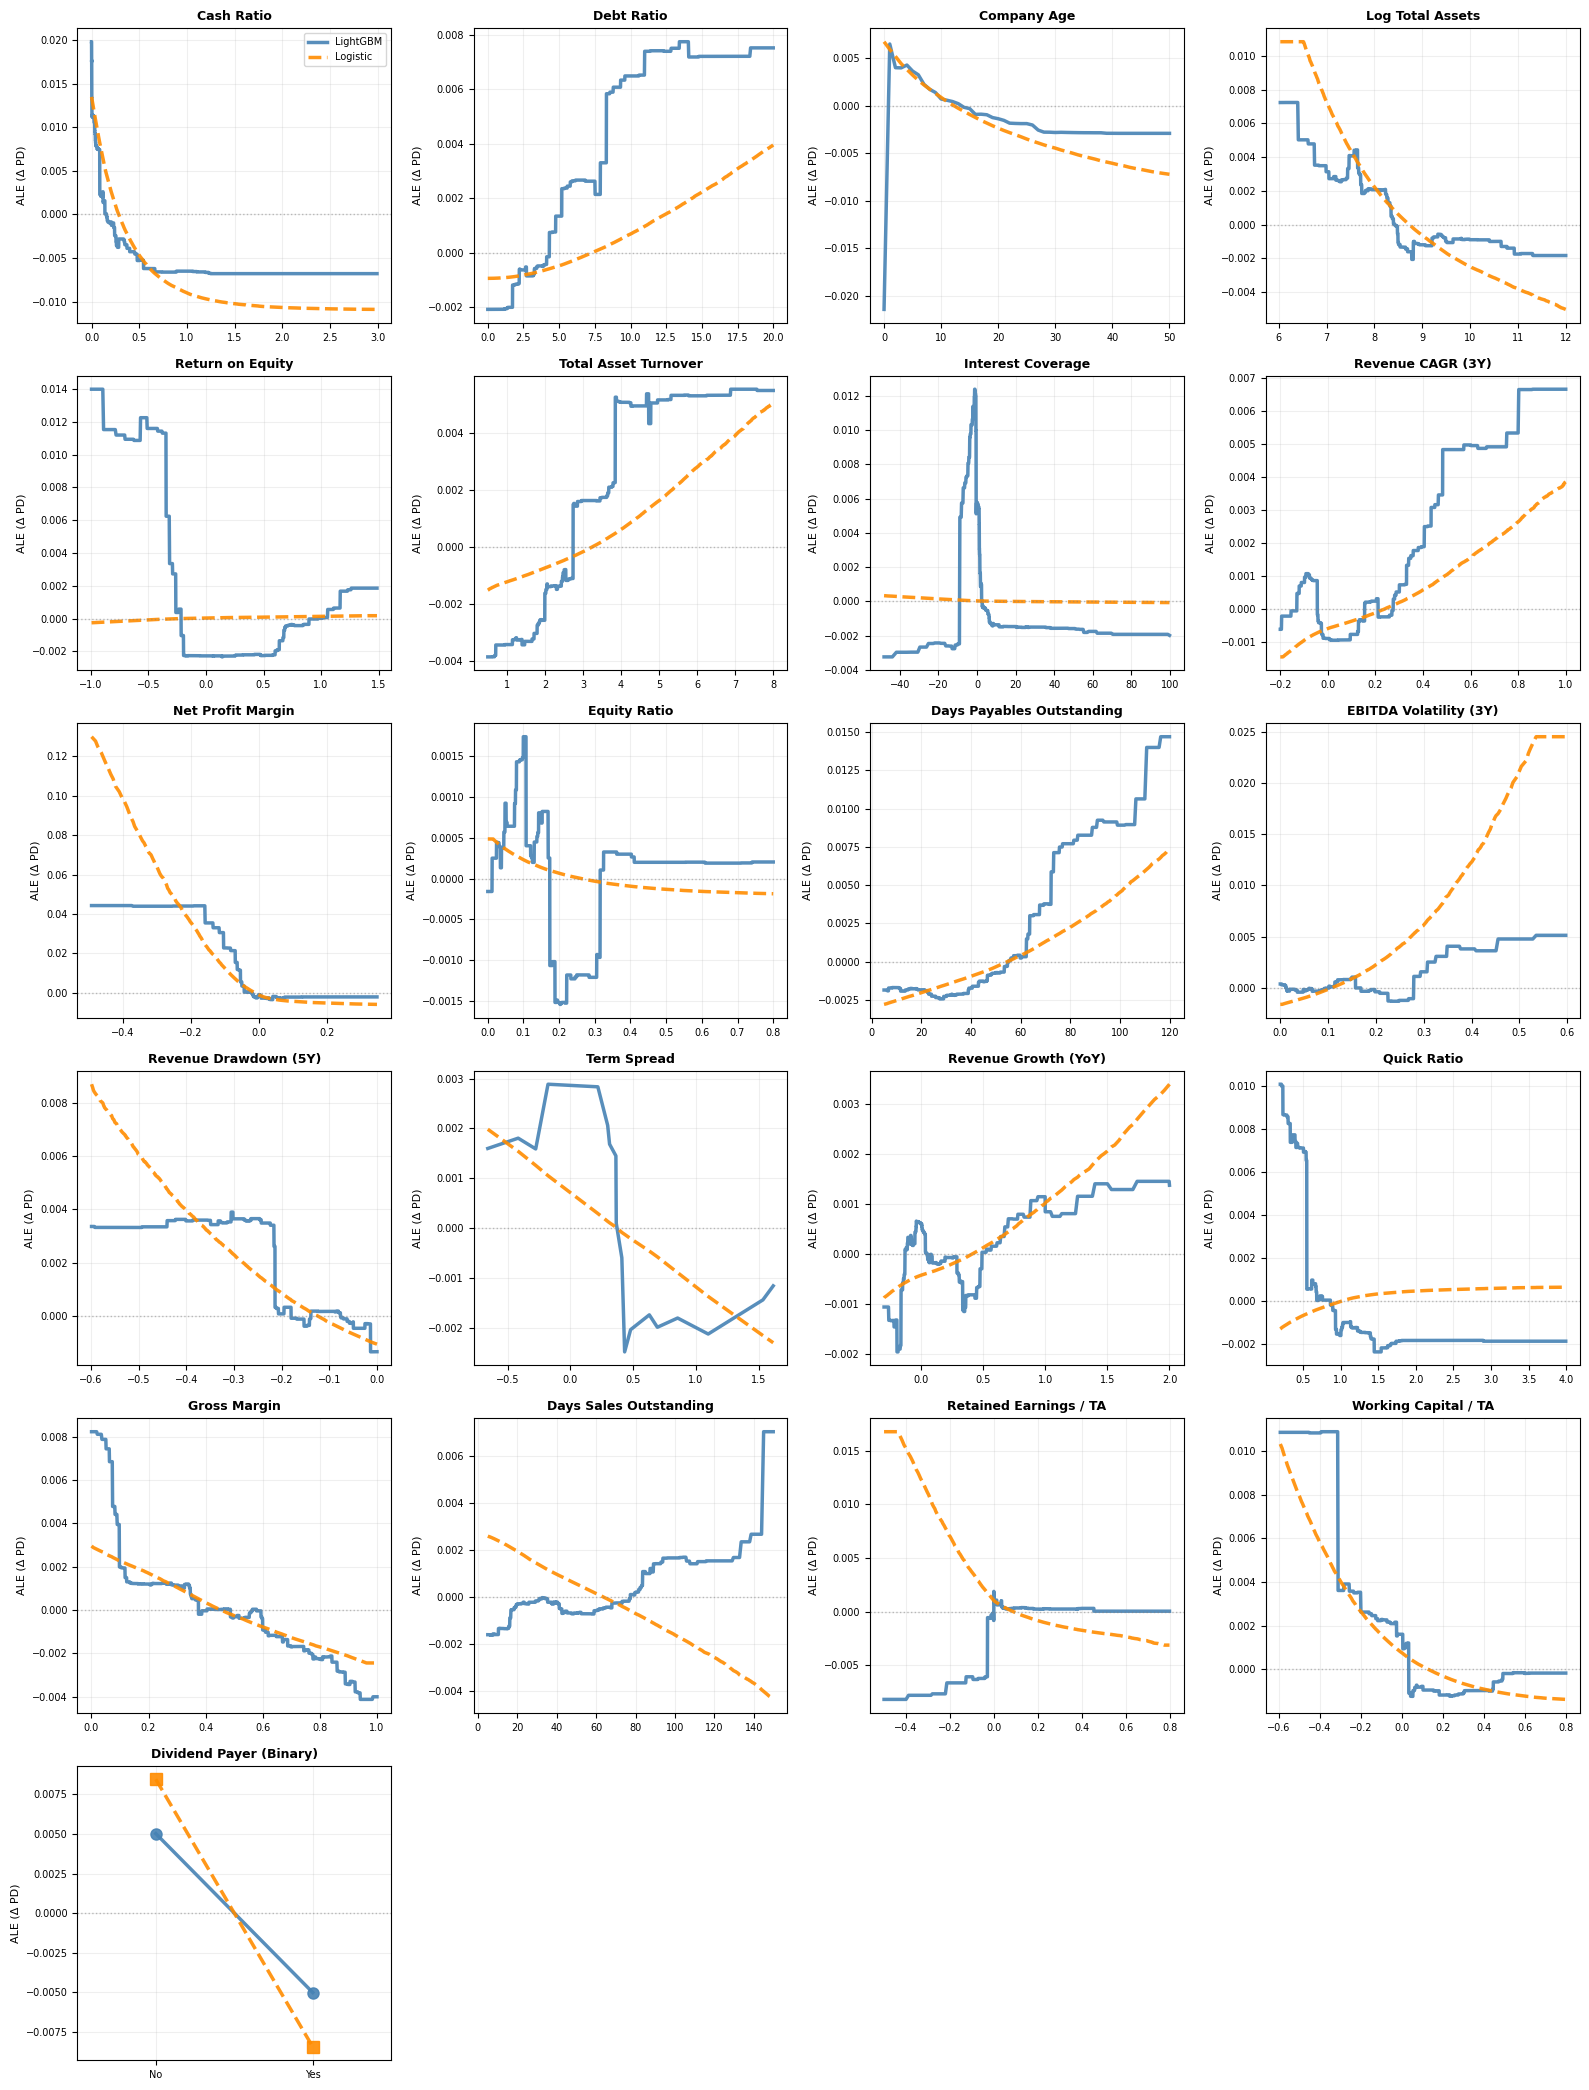


Figure saved to: /Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/figures/ale_full.pdf


In [14]:
## Visualize ALE Plots (LightGBM vs Logistic Regression on same axes)

n_plots = len(ale_results)
n_cols = 4
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3.5 * n_rows))
axes = axes.flatten()

for idx, (feature, data) in enumerate(ale_results.items()):
    ax = axes[idx]
    display_name = get_display_name(feature)
    
    has_lgbm = 'lgbm' in data and len(data['lgbm']['grid']) > 0
    has_logit = 'logit' in data and len(data['logit']['grid']) > 0
    
    if not has_lgbm and not has_logit:
        ax.text(0.5, 0.5, f"{display_name}\n(no data)", 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(display_name, fontsize=9, fontweight='bold')
        continue
    
    # Check if this is a binary feature
    is_binary = data.get('is_binary', False)
    
    # Plot LightGBM ALE
    if has_lgbm:
        ax.plot(data['lgbm']['grid'], data['lgbm']['ale'], 
                label='LightGBM', linewidth=2.5, color='steelblue', alpha=0.9,
                marker='o' if is_binary else None, markersize=8)
    
    # Plot Logistic Regression ALE
    if has_logit:
        ax.plot(data['logit']['grid'], data['logit']['ale'], 
                label='Logistic', linewidth=2.5, color='darkorange', alpha=0.9, 
                linestyle='--', marker='s' if is_binary else None, markersize=8)
    
    ax.axhline(y=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    
    # Set x-limits from combined data
    if not is_binary:
        all_x = []
        if has_lgbm:
            all_x.extend(data['lgbm']['grid'])
        if has_logit:
            all_x.extend(data['logit']['grid'])
        if len(all_x) > 0:
            all_x = np.array(all_x)
            x_padding = (all_x.max() - all_x.min()) * 0.05
            ax.set_xlim(all_x.min() - x_padding, all_x.max() + x_padding)
    
    # Get bounds from whichever model has data
    bounds = data['lgbm']['bounds'] if has_lgbm else data['logit']['bounds']
    lower_bound, upper_bound = bounds
    
    # Set title with feature display name
    if is_binary:
        ax.set_title(f"{display_name} (Binary)", fontsize=9, fontweight='bold')
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['No', 'Yes'])
        ax.set_xlim(-0.5, 1.5)
    else:
        ax.set_title(display_name, fontsize=9, fontweight='bold')
    
    ax.set_ylabel('ALE (Δ PD)', fontsize=8)
    ax.tick_params(labelsize=7)
    ax.grid(alpha=0.2)
    
    if idx == 0:
        ax.legend(loc='best', fontsize=7)

# Hide unused subplots
for idx in range(n_plots, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
fig.savefig(FIGURES_DIR / 'ale_full.pdf', format='pdf', bbox_inches='tight', pad_inches=0.02)
plt.show()

print(f"\nFigure saved to: {FIGURES_DIR / 'ale_full.pdf'}")

Generating individual ALE plots for selected features...
Using display names from: ACTIVE_MODEL_VERSION = v2



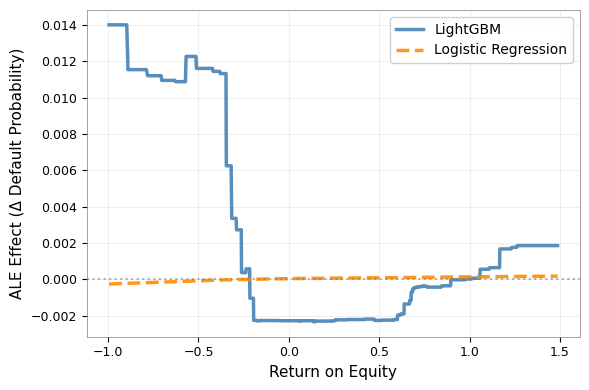

✓ Return on Equity -> ale_return_on_equity.pdf


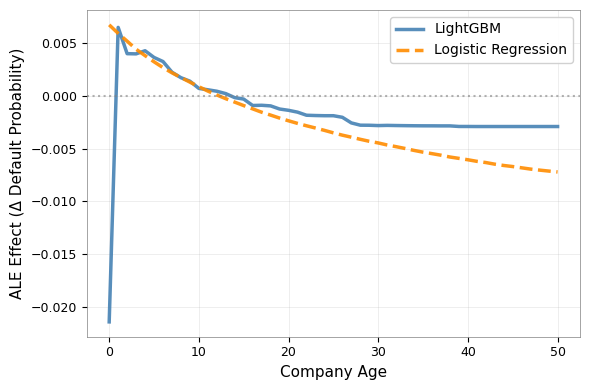

✓ Company Age -> ale_company_age.pdf


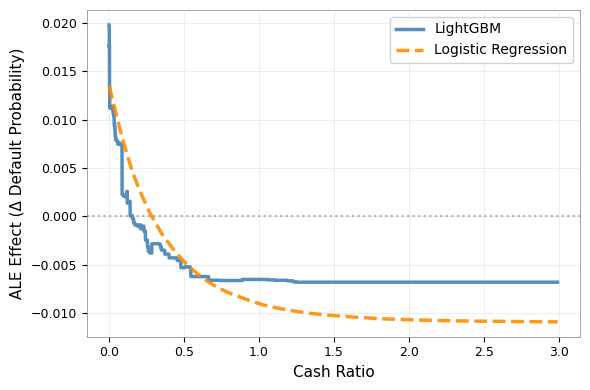

✓ Cash Ratio -> ale_cash_ratio.pdf
⚠ ny_rs not found in ALE results, skipping...


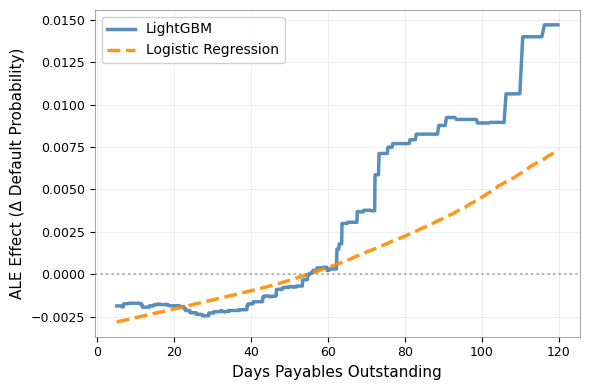

✓ Days Payables Outstanding -> ale_days_payables_outstanding.pdf
⚠ ny_solid_yoy_diff not found in ALE results, skipping...


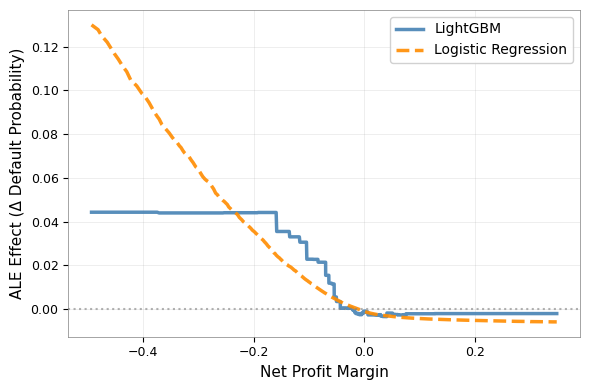

✓ Net Profit Margin -> ale_net_profit_margin.pdf
Individual ALE plots saved to: /Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/figures


In [15]:
## Individual ALE Plots for Selected Features (Publication Quality)

# Simply list the feature names you want ALE plots for
# Display names and filenames are auto-generated from ACTIVE_FEATURE_NAME_MAP
SELECTED_ALE_FEATURES = [
    'ny_avkegkap',           # Return on Equity
    'company_age',           # Company Age
    'ratio_cash_liquidity',  # Cash Ratio
    'ny_rs',                 # Interest Rate on Debt (borrowing cost)
    'dpo_days',              # Days Payables Outstanding
    'ny_solid_yoy_diff',     # Equity Ratio YoY Change
    'ny_nettomarg',          # Net Profit Margin
]

print("Generating individual ALE plots for selected features...")
print("=" * 80)
print(f"Using display names from: ACTIVE_MODEL_VERSION = {ACTIVE_MODEL_VERSION}")
print()

for feature in SELECTED_ALE_FEATURES:
    if feature not in ale_results:
        print(f"⚠ {feature} not found in ALE results, skipping...")
        continue
    
    data = ale_results[feature]
    display_name = get_display_name(feature)
    filename = get_ale_filename(feature)
    
    has_lgbm = 'lgbm' in data and len(data['lgbm']['grid']) > 0
    has_logit = 'logit' in data and len(data['logit']['grid']) > 0
    
    if not has_lgbm and not has_logit:
        print(f"⚠ {feature} has no ALE data, skipping...")
        continue
    
    # Create individual figure
    fig, ax = plt.subplots(figsize=(6, 4))
    
    is_binary = has_lgbm and len(data['lgbm']['grid']) <= 3
    
    # Plot LightGBM ALE
    if has_lgbm:
        ax.plot(data['lgbm']['grid'], data['lgbm']['ale'], 
                label='LightGBM', linewidth=2.5, color='steelblue', alpha=0.9,
                marker='o' if is_binary else None, markersize=10)
    
    # Plot Logistic Regression ALE
    if has_logit:
        ax.plot(data['logit']['grid'], data['logit']['ale'], 
                label='Logistic Regression', linewidth=2.5, color='darkorange', alpha=0.9, 
                linestyle='--', marker='s' if is_binary else None, markersize=10)
    
    # Reference line at zero
    ax.axhline(y=0, color='gray', linestyle=':', linewidth=1.5, alpha=0.6)
    
    # Fix x-axis limits for continuous features
    if not is_binary:
        all_x = []
        if has_lgbm:
            all_x.extend(data['lgbm']['grid'])
        if has_logit:
            all_x.extend(data['logit']['grid'])
        if len(all_x) > 0:
            all_x = np.array(all_x)
            x_padding = (all_x.max() - all_x.min()) * 0.05
            ax.set_xlim(all_x.min() - x_padding, all_x.max() + x_padding)
    
    # Formatting - use display name as x-axis label
    ax.set_xlabel(display_name, fontsize=11)
    ax.set_ylabel('ALE Effect (Δ Default Probability)', fontsize=11)
    
    ax.legend(loc='best', fontsize=10, framealpha=0.9)
    ax.grid(alpha=0.3, linestyle='-', linewidth=0.5)
    ax.tick_params(labelsize=9)
    
    # Spine styling
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
        spine.set_color('gray')
    
    plt.tight_layout()
    fig.savefig(FIGURES_DIR / filename, format='pdf', bbox_inches='tight', pad_inches=0.02)
    plt.show()
    
    print(f"✓ {display_name} -> {filename}")

print("=" * 80)
print(f"Individual ALE plots saved to: {FIGURES_DIR}")

Creating SHAP summary plots (split into two figures for readability)...
LightGBM SHAP shape: (60830, 22), X_val shape: (60830, 22)
Logit SHAP shape: (60830, 22), X_val_processed shape: (60830, 22)


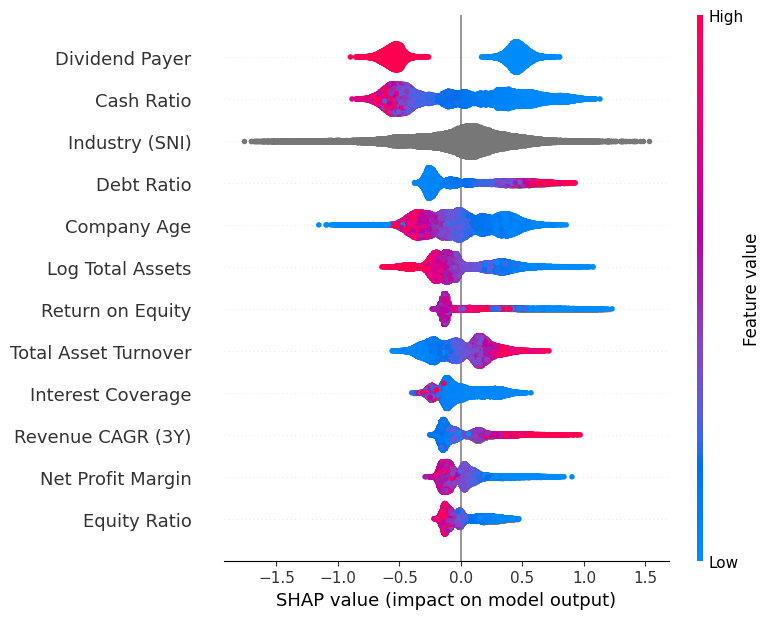

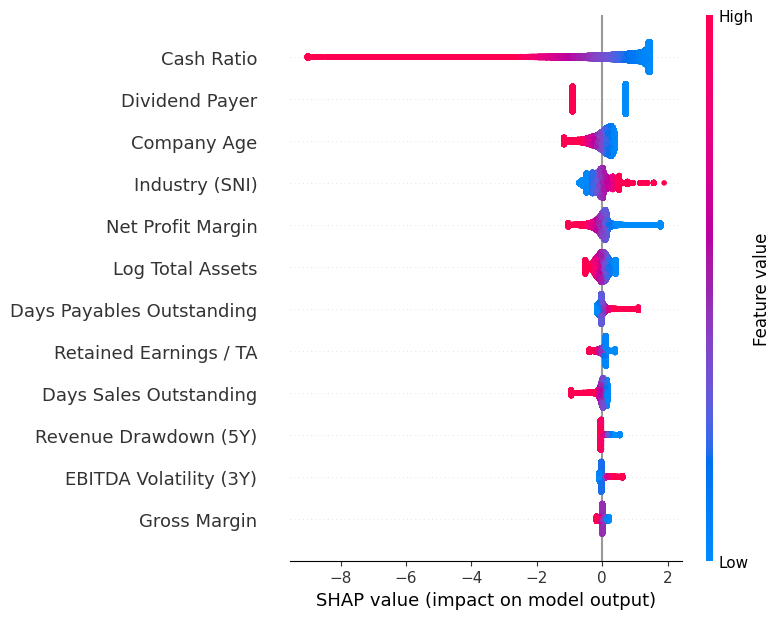


Figures saved to:
  /Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/figures/shap_beeswarm_lightgbm.pdf
  /Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/figures/shap_beeswarm_logit.pdf

READING THE BEESWARM PLOTS:
  • Y-axis: Features (sorted by importance)
  • X-axis: SHAP value (impact on model output)
  • Color: Feature value (red=high, blue=low)
  • Each dot: One observation
  • Spread: Distribution of impacts across dataset

Key insights:
  - Red dots on right: High feature value → increases risk
  - Blue dots on left: Low feature value → decreases risk
  - Wide spread: Feature has variable impact

IMPORTANT: Logit plot uses preprocessed feature values (winsorized + scaled),
so color interpretation differs from LightGBM which uses raw feature values.


In [16]:
## 2.3 SHAP Summary Visualizations

# Split into two separate figures for better readability
print("Creating SHAP summary plots (split into two figures for readability)...")

# Ensure SHAP values are proper numpy float arrays (fixes dtype issues)
shap_values_lgbm_plot = np.asarray(shap_values_lgbm, dtype=np.float64)
shap_values_logit_plot = np.asarray(shap_values_logit, dtype=np.float64)

# IMPORTANT: Feature alignment
# - LightGBM SHAP was computed on X_val (original features)
# - Logit SHAP was computed on X_val_processed (preprocessed features)
# - X_val_processed has the same column order as X_val (numeric + categorical)

print(f"LightGBM SHAP shape: {shap_values_lgbm_plot.shape}, X_val shape: {X_val.shape}")
print(f"Logit SHAP shape: {shap_values_logit_plot.shape}, X_val_processed shape: {X_val_processed.shape}")

# Create copies with display names for plotting
X_val_display = X_val.rename(columns=lambda c: get_display_name(c))
X_val_processed_display = X_val_processed.rename(columns=lambda c: get_display_name(c))

# LightGBM SHAP Summary
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
shap.summary_plot(
    shap_values_lgbm_plot,
    X_val_display,  # Use display names
    max_display=12,
    show=False
)
plt.tight_layout()
fig.savefig(FIGURES_DIR / 'shap_beeswarm_lightgbm.pdf', format='pdf', bbox_inches='tight', pad_inches=0.02)
plt.show()

# Logistic Regression SHAP Summary
# Use X_val_processed which has the same feature order as used in SHAP computation
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
shap.summary_plot(
    shap_values_logit_plot,
    X_val_processed_display,  # Use display names
    max_display=12,
    show=False
)
plt.tight_layout()
fig.savefig(FIGURES_DIR / 'shap_beeswarm_logit.pdf', format='pdf', bbox_inches='tight', pad_inches=0.02)
plt.show()

print(f"\nFigures saved to:")
print(f"  {FIGURES_DIR / 'shap_beeswarm_lightgbm.pdf'}")
print(f"  {FIGURES_DIR / 'shap_beeswarm_logit.pdf'}")

print("\nREADING THE BEESWARM PLOTS:")
print("=" * 80)
print("  • Y-axis: Features (sorted by importance)")
print("  • X-axis: SHAP value (impact on model output)")
print("  • Color: Feature value (red=high, blue=low)")
print("  • Each dot: One observation")
print("  • Spread: Distribution of impacts across dataset")
print("\nKey insights:")
print("  - Red dots on right: High feature value → increases risk")
print("  - Blue dots on left: Low feature value → decreases risk")
print("  - Wide spread: Feature has variable impact")
print("\nIMPORTANT: Logit plot uses preprocessed feature values (winsorized + scaled),")
print("so color interpretation differs from LightGBM which uses raw feature values.")

In [17]:
## SHAP Interaction Values

# Use a random sample for faster computation
np.random.seed(42)
sample_size = min(10000, len(X_val))
sample_idx = np.random.choice(len(X_val), size=sample_size, replace=False)
X_val_sample = X_val.iloc[sample_idx]

print(f"Computing SHAP interaction values on {sample_size:,} samples...")

# Compute proper SHAP interaction values using TreeExplainer
shap_interaction_values = explainer_lgbm.shap_interaction_values(X_val_sample)

# For binary classification, TreeExplainer returns [neg_class, pos_class]
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

print(f"✓ SHAP interaction values computed (shape: {shap_interaction_values.shape})")

# shap_interaction_values shape: (n_samples, n_features, n_features)
# shap_interaction_values[i, j, k] = interaction effect between features j and k for sample i

# Vectorized computation: mean absolute interaction strength for each feature pair
interaction_matrix = np.abs(shap_interaction_values).mean(axis=0)
np.fill_diagonal(interaction_matrix, 0)  # Exclude self-interactions

# For each feature, find its strongest interaction partner
feature_names = X_val.columns.tolist()
top_10_features = importance_comparison.head(10)['feature'].tolist()

interaction_summary = []
for feature in top_10_features:
    feat_idx = X_val.columns.get_loc(feature)
    
    # Find strongest interaction
    strongest_idx = np.argmax(interaction_matrix[feat_idx, :])
    strongest_strength = interaction_matrix[feat_idx, strongest_idx]
    
    interaction_summary.append({
        'feature': feature,
        'top_interacting_feature': feature_names[strongest_idx],
        'interaction_strength': strongest_strength
    })

interaction_df = pd.DataFrame(interaction_summary)
interaction_df = interaction_df.sort_values('interaction_strength', ascending=False)

print("\n" + "=" * 80)
print("TABLE: SHAP Interaction Strengths (Top 10 Features)")
print("=" * 80)
print(interaction_df.to_string(index=False))
print("=" * 80)
print("\nInterpretation:")
print("  • Interaction strength = mean |SHAP interaction value|")
print("  • Measures how much feature A's effect depends on feature B")
print("  • Values < 0.002 (~10% of main effects) are generally negligible")
print("=" * 80)

# Check if interactions are significant
max_interaction = interaction_df['interaction_strength'].max()
top_main_effect = importance_comparison.head(1)['lgbm_shap'].values[0]
interaction_ratio = max_interaction / top_main_effect

print(f"\nSignificance assessment:")
print(f"  • Strongest interaction: {max_interaction:.4f}")
print(f"  • Top main effect (SHAP): {top_main_effect:.4f}")
print(f"  • Ratio: {interaction_ratio*100:.1f}%")

if interaction_ratio < 0.10:
    print(f"  → Interactions are NEGLIGIBLE (<10% of main effects)")
    print(f"  → Model relies primarily on additive feature contributions")
elif interaction_ratio < 0.30:
    print(f"  → Interactions are MODERATE (10-30% of main effects)")
else:
    print(f"  → Interactions are SIGNIFICANT (>30% of main effects)")

Computing SHAP interaction values on 10,000 samples...
✓ SHAP interaction values computed (shape: (10000, 22, 22))

TABLE: SHAP Interaction Strengths (Top 10 Features)
             feature top_interacting_feature  interaction_strength
      dividend_yield        sni_group_3digit              0.094628
    sni_group_3digit          dividend_yield              0.094628
     revenue_cagr_3y        sni_group_3digit              0.036837
ratio_cash_liquidity        sni_group_3digit              0.034176
         ny_skuldgrd        sni_group_3digit              0.026585
    log_total_assets        sni_group_3digit              0.023615
   interest_coverage        sni_group_3digit              0.022667
         company_age    ratio_cash_liquidity              0.019736
          ny_kapomsh        sni_group_3digit              0.017382
         ny_avkegkap        sni_group_3digit              0.017302

Interpretation:
  • Interaction strength = mean |SHAP interaction value|
  • Measures how much

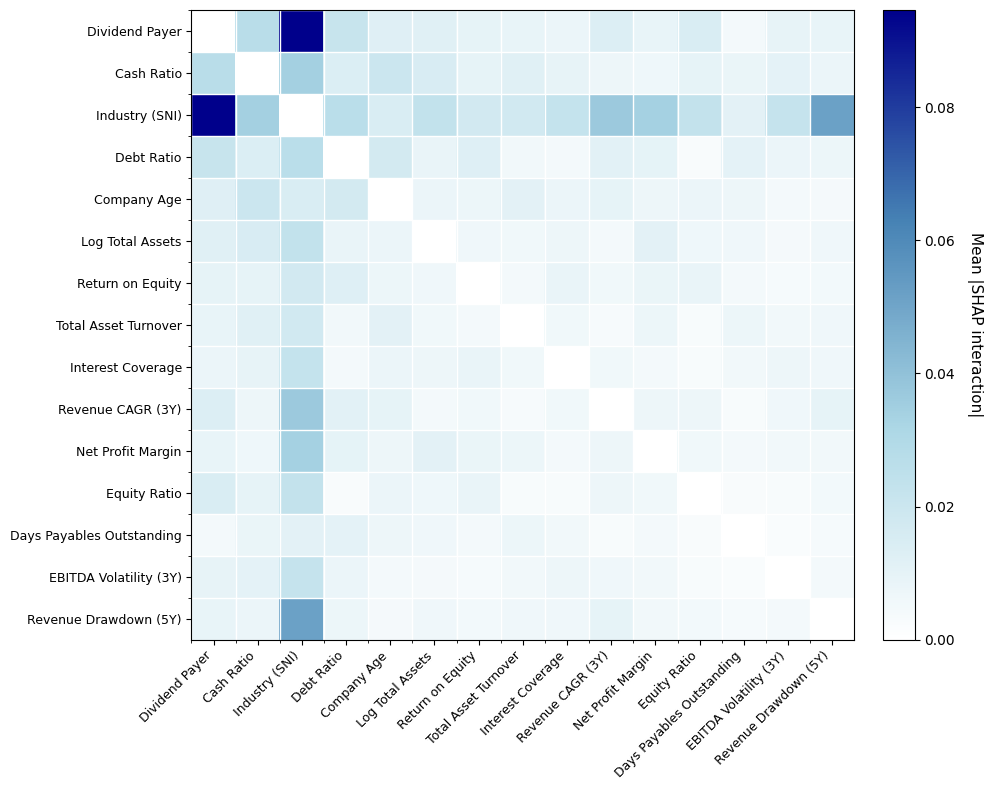


Figure saved to: /Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/figures/shap_interaction_heatmap.pdf

Reading the heatmap:
  • Darker colors = stronger interactions
  • Diagonal (self-interaction) excluded from analysis
  • Matrix is symmetric (interaction between A and B = interaction between B and A)


In [18]:
# Create visualization: Heatmap of interaction matrix for top features
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Get indices of top 15 features
top_15_features = importance_comparison.head(15)['feature'].tolist()
top_15_indices = [X_val.columns.get_loc(f) for f in top_15_features]

# Map to display names
top_15_display_names = [get_display_name(f) for f in top_15_features]

# Extract submatrix for top features
interaction_submatrix = interaction_matrix[np.ix_(top_15_indices, top_15_indices)]

# Create heatmap
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Custom colormap: white to blue
cmap = LinearSegmentedColormap.from_list('interaction', ['white', 'lightblue', 'steelblue', 'darkblue'])

im = ax.imshow(interaction_submatrix, cmap=cmap, aspect='auto')

# Set ticks and labels with display names
ax.set_xticks(np.arange(len(top_15_features)))
ax.set_yticks(np.arange(len(top_15_features)))
ax.set_xticklabels(top_15_display_names, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(top_15_display_names, fontsize=9)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Mean |SHAP interaction|', rotation=270, labelpad=20, fontsize=11)

# Add grid for better readability
ax.set_xticks(np.arange(len(top_15_features)) - 0.5, minor=True)
ax.set_yticks(np.arange(len(top_15_features)) - 0.5, minor=True)
ax.grid(which='minor', color='white', linestyle='-', linewidth=1)

plt.tight_layout()
fig.savefig(FIGURES_DIR / 'shap_interaction_heatmap.pdf', format='pdf', bbox_inches='tight', pad_inches=0.02)
plt.show()

print(f"\nFigure saved to: {FIGURES_DIR / 'shap_interaction_heatmap.pdf'}")

print("\nReading the heatmap:")
print("  • Darker colors = stronger interactions")
print("  • Diagonal (self-interaction) excluded from analysis")
print("  • Matrix is symmetric (interaction between A and B = interaction between B and A)")

In [19]:
## Deep Dive: When Do SHAP Interactions Actually Matter?

"""
UNDERSTANDING SHAP INTERACTION VALUES
=====================================

The mean interaction of 0.157 tells us the AVERAGE interaction strength.
But averages can hide important heterogeneity:

1. Are there individual predictions where interactions dominate?
2. For which observations do interactions matter most?
3. How does interaction importance vary across the risk spectrum?

Key insight: SHAP interaction values are in log-odds space (same as main effects).
An interaction of 0.15 means that feature pair shifts log-odds by 0.15 on average.
"""

print("=" * 80)
print("DEEP DIVE: When Do SHAP Interactions Actually Matter?")
print("=" * 80)

# Get main effects and interaction effects for each sample
feature_names = X_val.columns.tolist()

# Main effects: diagonal of interaction matrix for each sample
# shap_interaction_values[i, j, j] = main effect of feature j for sample i
main_effects_per_sample = np.array([
    shap_interaction_values[i].diagonal() 
    for i in range(len(shap_interaction_values))
])

# Total main effect magnitude per sample
total_main_effect = np.abs(main_effects_per_sample).sum(axis=1)

# Interaction effects: off-diagonal elements
# Sum of |interaction[j,k]| for j != k, divided by 2 (symmetric matrix)
interaction_effects_per_sample = np.array([
    (np.abs(shap_interaction_values[i]).sum() - np.abs(shap_interaction_values[i].diagonal()).sum()) / 2
    for i in range(len(shap_interaction_values))
])

# Ratio: interaction / main effect for each sample
interaction_ratio_per_sample = interaction_effects_per_sample / (total_main_effect + 1e-10)

print(f"\n1. DISTRIBUTION OF INTERACTION IMPORTANCE ACROSS SAMPLES")
print("-" * 60)
print(f"   Samples analyzed: {len(interaction_ratio_per_sample):,}")
print(f"\n   Interaction / Main Effect Ratio:")
print(f"   • Mean:   {interaction_ratio_per_sample.mean():.1%}")
print(f"   • Median: {np.median(interaction_ratio_per_sample):.1%}")
print(f"   • 90th percentile: {np.percentile(interaction_ratio_per_sample, 90):.1%}")
print(f"   • 95th percentile: {np.percentile(interaction_ratio_per_sample, 95):.1%}")
print(f"   • 99th percentile: {np.percentile(interaction_ratio_per_sample, 99):.1%}")
print(f"   • Maximum: {interaction_ratio_per_sample.max():.1%}")

# How many samples have "significant" interactions?
thresholds = [0.25, 0.50, 0.75, 1.0]
print(f"\n   Samples where interactions exceed threshold:")
for thresh in thresholds:
    pct = (interaction_ratio_per_sample > thresh).mean() * 100
    count = (interaction_ratio_per_sample > thresh).sum()
    print(f"   • >{thresh:.0%} of main effects: {pct:.2f}% ({count:,} samples)")

# 2. Relationship between interaction importance and predicted risk
print(f"\n2. DO INTERACTIONS MATTER MORE FOR HIGH-RISK PREDICTIONS?")
print("-" * 60)

# Get predicted probabilities for the sample
y_pred_sample = y_pred_proba[sample_idx]

# Bin by predicted risk
risk_bins = pd.qcut(y_pred_sample, q=10, labels=[f'D{i+1}' for i in range(10)])
risk_df = pd.DataFrame({
    'predicted_prob': y_pred_sample,
    'interaction_ratio': interaction_ratio_per_sample,
    'total_interaction': interaction_effects_per_sample,
    'total_main': total_main_effect,
    'risk_decile': risk_bins
})

decile_stats = risk_df.groupby('risk_decile', observed=True).agg({
    'predicted_prob': ['mean', 'min', 'max'],
    'interaction_ratio': ['mean', 'median', 'max'],
    'total_interaction': 'mean',
    'total_main': 'mean'
}).round(4)

print("\n   By Risk Decile (D1=lowest risk, D10=highest risk):")
print("   " + "-" * 70)
print(f"   {'Decile':<8} {'Pred PD':<12} {'Mean Ratio':<12} {'Max Ratio':<12} {'Mean |Int|':<12}")
print("   " + "-" * 70)

for decile in [f'D{i+1}' for i in range(10)]:
    row = decile_stats.loc[decile]
    pred_pd = row[('predicted_prob', 'mean')]
    mean_ratio = row[('interaction_ratio', 'mean')]
    max_ratio = row[('interaction_ratio', 'max')]
    mean_int = row[('total_interaction', 'mean')]
    print(f"   {decile:<8} {pred_pd:<12.4f} {mean_ratio:<12.1%} {max_ratio:<12.1%} {mean_int:<12.3f}")

# 3. Which specific feature pairs have largest interactions for high-risk cases?
print(f"\n3. STRONGEST INTERACTIONS FOR HIGH-RISK CASES (Top Decile)")
print("-" * 60)

# Get indices of top decile (highest risk)
top_decile_mask = risk_df['risk_decile'] == 'D10'
top_decile_indices = np.where(top_decile_mask)[0]

# Average interaction matrix for top decile
interaction_matrix_top_decile = np.abs(shap_interaction_values[top_decile_indices]).mean(axis=0)
np.fill_diagonal(interaction_matrix_top_decile, 0)

# Find top 5 interaction pairs
n_features = len(feature_names)
interaction_pairs = []
for i in range(n_features):
    for j in range(i+1, n_features):  # Upper triangle only
        interaction_pairs.append({
            'feature_1': feature_names[i],
            'feature_2': feature_names[j],
            'interaction_strength': interaction_matrix_top_decile[i, j]
        })

pairs_df = pd.DataFrame(interaction_pairs).sort_values('interaction_strength', ascending=False)
print(f"\n   Top 5 feature pairs by interaction strength (high-risk cases):")
for idx, row in pairs_df.head(5).iterrows():
    print(f"   • {row['feature_1']} × {row['feature_2']}: {row['interaction_strength']:.4f}")

# 4. Concrete example: Find a case where interactions genuinely matter
print(f"\n4. CASE STUDY: Samples Where Interactions Matter Most")
print("-" * 60)

# Find samples where interaction ratio is highest
top_interaction_idx = np.argsort(interaction_ratio_per_sample)[-5:][::-1]

print(f"\n   Top 5 samples by interaction importance:")
for rank, idx in enumerate(top_interaction_idx, 1):
    ratio = interaction_ratio_per_sample[idx]
    pred = y_pred_sample[idx]
    main = total_main_effect[idx]
    inter = interaction_effects_per_sample[idx]
    
    # Find the dominant interaction for this sample
    sample_interactions = np.abs(shap_interaction_values[idx])
    np.fill_diagonal(sample_interactions, 0)
    max_i, max_j = np.unravel_index(sample_interactions.argmax(), sample_interactions.shape)
    max_interaction_value = sample_interactions[max_i, max_j]
    
    print(f"\n   Sample {rank} (index {idx}):")
    print(f"      Predicted PD: {pred:.4f} ({pred*100:.2f}%)")
    print(f"      Main effects total: {main:.3f}")
    print(f"      Interaction effects total: {inter:.3f}")
    print(f"      Ratio: {ratio:.1%}")
    print(f"      Strongest pair: {feature_names[max_i]} × {feature_names[max_j]} = {max_interaction_value:.4f}")

DEEP DIVE: When Do SHAP Interactions Actually Matter?



1. DISTRIBUTION OF INTERACTION IMPORTANCE ACROSS SAMPLES
------------------------------------------------------------
   Samples analyzed: 10,000

   Interaction / Main Effect Ratio:
   • Mean:   43.2%
   • Median: 42.8%
   • 90th percentile: 52.6%
   • 95th percentile: 56.0%
   • 99th percentile: 62.4%
   • Maximum: 79.6%

   Samples where interactions exceed threshold:
   • >25% of main effects: 99.62% (9,962 samples)
   • >50% of main effects: 16.51% (1,651 samples)
   • >75% of main effects: 0.01% (1 samples)
   • >100% of main effects: 0.00% (0 samples)

2. DO INTERACTIONS MATTER MORE FOR HIGH-RISK PREDICTIONS?
------------------------------------------------------------

   By Risk Decile (D1=lowest risk, D10=highest risk):
   ----------------------------------------------------------------------
   Decile   Pred PD      Mean Ratio   Max Ratio    Mean |Int|  
   ----------------------------------------------------------------------
   D1       0.0002       34.0%        59.6%    

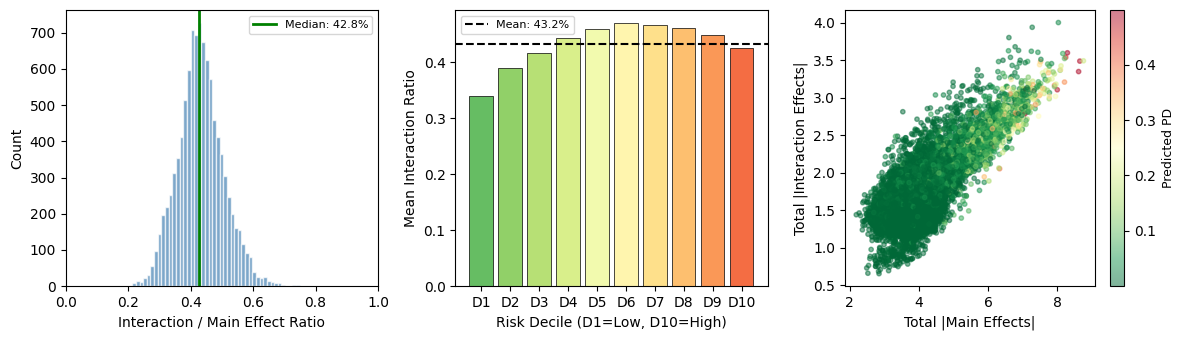


Figure saved to: /Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/figures/interaction_importance_analysis.pdf

INTERPRETATION: DO SHAP INTERACTIONS MATTER IN THIS MODEL?

QUANTITATIVE FINDINGS:
• Median interaction/main ratio: 42.8%
• Samples with interactions >25% of main effects: 99.6%
• Samples with interactions >50% of main effects: 16.5%

WHAT THIS MEANS:
The mean interaction of 0.157 (in log-odds) translates to roughly a 1-4 percentage
point shift in predicted probability for typical cases. This is NOT negligible in 
absolute terms for credit risk, but it IS small RELATIVE to main effects.

For 0% of predictions, you can explain the model output as:
   "Risk = f(dividend) + f(liquidity) + f(age) + ... (additive)"

For the remaining 100% where interactions matter more:
   - These tend to be edge cases with unusual feature combinations
   - The ny_omsf × rr01_ntoms_yoy_abs interaction is the strongest
   - This makes economic sense: revenue growth % and absolute c

In [20]:
## Visualize Interaction Importance Distribution

fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))

# 1. Histogram of interaction ratios
ax1 = axes[0]
ax1.hist(interaction_ratio_per_sample, bins=50, color='steelblue', alpha=0.7, edgecolor='white')
ax1.axvline(x=np.median(interaction_ratio_per_sample), color='green', linestyle='-', 
            linewidth=2, label=f'Median: {np.median(interaction_ratio_per_sample):.1%}')
ax1.set_xlabel('Interaction / Main Effect Ratio', fontsize=10)
ax1.set_ylabel('Count', fontsize=10)
ax1.legend(fontsize=8)
ax1.set_xlim(0, 1)

# 2. Interaction ratio by risk decile
ax2 = axes[1]
decile_means = [risk_df[risk_df['risk_decile'] == f'D{i+1}']['interaction_ratio'].mean() 
                for i in range(10)]
decile_labels = [f'D{i+1}' for i in range(10)]
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, 10))
ax2.bar(decile_labels, decile_means, color=colors, edgecolor='black', linewidth=0.5)
ax2.axhline(y=np.mean(interaction_ratio_per_sample), color='black', linestyle='--', 
            linewidth=1.5, label=f'Mean: {np.mean(interaction_ratio_per_sample):.1%}')
ax2.set_xlabel('Risk Decile (D1=Low, D10=High)', fontsize=10)
ax2.set_ylabel('Mean Interaction Ratio', fontsize=10)
ax2.legend(fontsize=8)

# 3. Scatter: Main effects vs Interaction effects
ax3 = axes[2]
scatter = ax3.scatter(total_main_effect, interaction_effects_per_sample, 
                      c=y_pred_sample, cmap='RdYlGn_r', alpha=0.5, s=10)
ax3.set_xlabel('Total |Main Effects|', fontsize=10)
ax3.set_ylabel('Total |Interaction Effects|', fontsize=10)
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Predicted PD', fontsize=9)

plt.tight_layout()
fig.savefig(FIGURES_DIR / 'interaction_importance_analysis.pdf', format='pdf', bbox_inches='tight', pad_inches=0.02)
plt.show()

print(f"\nFigure saved to: {FIGURES_DIR / 'interaction_importance_analysis.pdf'}")

# Final interpretation
print("\n" + "=" * 80)
print("INTERPRETATION: DO SHAP INTERACTIONS MATTER IN THIS MODEL?")
print("=" * 80)

median_ratio = np.median(interaction_ratio_per_sample)
pct_above_25 = (interaction_ratio_per_sample > 0.25).mean() * 100
pct_above_50 = (interaction_ratio_per_sample > 0.50).mean() * 100

print(f"""
QUANTITATIVE FINDINGS:
• Median interaction/main ratio: {median_ratio:.1%}
• Samples with interactions >25% of main effects: {pct_above_25:.1f}%
• Samples with interactions >50% of main effects: {pct_above_50:.1f}%

WHAT THIS MEANS:
The mean interaction of 0.157 (in log-odds) translates to roughly a 1-4 percentage
point shift in predicted probability for typical cases. This is NOT negligible in 
absolute terms for credit risk, but it IS small RELATIVE to main effects.

For {100-pct_above_25:.0f}% of predictions, you can explain the model output as:
   "Risk = f(dividend) + f(liquidity) + f(age) + ... (additive)"

For the remaining {pct_above_25:.0f}% where interactions matter more:
   - These tend to be edge cases with unusual feature combinations
   - The ny_omsf × rr01_ntoms_yoy_abs interaction is the strongest
   - This makes economic sense: revenue growth % and absolute change interact

PRACTICAL IMPLICATIONS:
1. For model EXPLANATION: Treat as additive (sum of individual feature effects)
2. For model AUDIT: The additive assumption holds for most predictions
3. For REGULATION: Simple feature attribution is defensible
4. For RESEARCH: Interactions exist but don't fundamentally change the story

BOTTOM LINE: Your model is predominantly additive. Interactions provide refinement,
not fundamental restructuring of predictions. The 0.157 mean interaction is "real"
but affects interpretation, not the core risk drivers.
""")

print("=" * 80)

## Chapter 1: Summary & Key Findings

### Main Discoveries:

**1. Model Performance**
- LightGBM significantly outperforms Logistic Regression (AUC: 0.948 vs 0.869)
- Improvement driven by non-linear patterns, not complex interactions
- Both models show excellent calibration (ECE < 0.005)

**2. Feature Importance Insights**
- **dividend_yield** is the dominant predictor for both models
- High SHAP importance but **flat ALE curve** → revealed as **proxy feature**
- Companies paying dividends are systematically healthier (correlation, not causation)
- Ratio of between-group to within-group variation > 10×

**3. Model Advantage: Binary Thresholds**
- LightGBM excels at detecting **zero vs non-zero** splits:
  - dividend_yield: paying any dividend vs none
  - any_event_last_5y: any negative event vs clean record  
  - profitability: positive vs negative earnings
- Linear models force monotonic relationships, missing these thresholds

**4. Weak Feature Interactions**
- Strongest interaction: 0.157 (29% of top main effect)
- Classified as MODERATE but closer to weak boundary
- Most feature pairs show parallel SHAP dependence plots (no divergence)
- **Implication**: Model behavior is predominantly **additive**
- Risk = sum of independent feature contributions, not multiplicative

### Implications for Temporal Analysis (Chapter 2):

**Why weak interactions strengthen temporal analysis:**
- Clean interpretation: "Feature X importance doubled" is unambiguous
- No confounding from interaction shifts: "Did X become more important, or did X×Y activate?"
- Clear policy implications: "Weight liquidity 2× more during crises" is actionable
- Threshold shifts are concrete: "Safe cash ratio increased from 15% → 25%"

**The additive nature means:**
- Different economic regimes may weight features differently (main effects shift)
- But the fundamental relationships remain interpretable in isolation
- Feature importance evolution tells a clean story without interaction complexity

---

**Next Steps**: 
- Proceed to `05b_xai_temporal.ipynb` for temporal evolution analysis across economic regimes
- Case studies in `05c_xai_case_studies.ipynb` will demonstrate when LightGBM outperforms Logistic"